# Initialization
## Import Libraries

In [1]:
# install librarires
import os
import tensorflow as tf
import numpy as np
import random

2025-07-14 09:03:19.972845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752483800.355300      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752483800.464404      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## ℹ️ Set Global Constants

In [2]:
# global variables
# set dataset directories


DATASET_DIR = "/kaggle/input/msrdailyactivity3d-rgb-videos-only"
DATASET_NAME = DATASET_DIR.split("/")[-1].replace("-", " ").title()

print(DATASET_NAME)

ALL_CLASS_NAMES = os.listdir(DATASET_DIR)

# Global constant variables -> 
NO_OF_CLASSES = len(ALL_CLASS_NAMES)
CLASSES_LIST = ALL_CLASS_NAMES[:NO_OF_CLASSES]

# Model Configuration
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
SEQUENCE_LENGTH = 5

# set drop out rate
DROPOUT_RATE = 0.5

# set datas
MAX_VIDEO_PER_CLASS = None

# split dataset
TEST_SIZE = 0.20

# model fit parameters
EPOCHS = 30
BATCH_SIZE = 24
VALIDATION_SPLIT = 0.20

# augmentation values
NOISE_FACTOR = 0.02
SHEAR_X= 1
SHEAR_Y= 1

# give a name of the model to save
MODEL_NAME = "Xception"

print(f"There are total {len(ALL_CLASS_NAMES)} classes, selected {NO_OF_CLASSES} classes")
print(f"Setting {MAX_VIDEO_PER_CLASS}/class to train the model.")
print(f"Image size {IMAGE_HEIGHT}x{IMAGE_WIDTH} with {SEQUENCE_LENGTH} sequence length")
print(f"Dropout rate: {DROPOUT_RATE}")
print(f"Train-Test split ratio {int((1-TEST_SIZE)*100)}/{int(TEST_SIZE*100)}")
print(f"Validation data from Train set {VALIDATION_SPLIT*100}%")

Msrdailyactivity3D Rgb Videos Only
There are total 16 classes, selected 16 classes
Setting None/class to train the model.
Image size 128x128 with 5 sequence length
Dropout rate: 0.5
Train-Test split ratio 80/20
Validation data from Train set 20.0%


## Set `Seed` Values

In [3]:
# set seeed to get similar values
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# 📌 Function Definition
## Resize and Frame Extraction

In [4]:
import cv2
from concurrent.futures import ThreadPoolExecutor

def resize_and_normalize_frame(frame, image_height, image_width):
    try:
        resized_frame = cv2.resize(frame, (image_width, image_height), interpolation=cv2.INTER_LINEAR)
        normalized_frame = resized_frame / 255.0
        return normalized_frame
    except Exception as e:
        print(f"Error processing frame: {e}")
        return None

def frames_extraction(video_path, 
                      sequence_length=SEQUENCE_LENGTH, 
                      image_height=IMAGE_HEIGHT, 
                      image_width=IMAGE_WIDTH):
    # Declare a list to store video frames
    frames_list = []

    # Check if video file exists
    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return None

    # Read the video file using VideoCapture with optimized settings
    video_reader = cv2.VideoCapture(video_path, cv2.CAP_FFMPEG)

    # Check if the video was opened successfully
    if not video_reader.isOpened():
        print(f"Error: Could not open video file {video_path}")
        video_reader.release()
        return None

    # Get the total number of frames in the video
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Ensure the video has enough frames
    if video_frames_count < sequence_length:
        print(f"Warning: Video {video_path} has only {video_frames_count} frames, less than required {sequence_length}")
        video_reader.release()
        return None

    # Calculate the interval after which frames will be sampled
    skip_frames_window = max(int(video_frames_count / sequence_length), 1)

    # Pre-allocate frame indices to extract
    frame_indices = [i * skip_frames_window for i in range(sequence_length)]

    # Read and process frames in parallel
    frames = []
    for idx in frame_indices:
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, idx)
        success, frame = video_reader.read()
        if not success or frame is None:
            print(f"Warning: Failed to read frame at index {idx} from {video_path}")
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

    # Release the VideoCapture object early
    video_reader.release()

    # Ensure the correct number of frames is read
    if len(frames) != sequence_length:
        print(f"Warning: Read {len(frames)} frames instead of {sequence_length} from {video_path}")
        return None

    # Process frames in parallel using ThreadPoolExecutor
    with ThreadPoolExecutor() as executor:
        processed_frames = list(executor.map(
            lambda f: resize_and_normalize_frame(f, image_height, image_width), 
            frames
        ))

    # Check for any failed frame processing
    if any(f is None for f in processed_frames):
        print(f"Warning: Some frames failed to process in {video_path}")
        return None

    # Convert to NumPy array
    frames_array = np.array(processed_frames, dtype=np.float32)

    return frames_array

In [5]:
 # # Iterate through all video files
 #        for file_name in files_list:
 #            video_file_path = os.path.join(class_path, file_name)

 #            # Extract frames using the updated frames_extraction function
 #            frames = frames_extraction(video_file_path, sequence_length, image_height, image_width)

 #            # Skip videos where frame extraction failed
 #            if frames is None:
 #                print(f"Skipping video {video_file_path} due to frame extraction failure")
 #                continue

 #            # Append the data to respective lists
 #            features.append(frames)
 #            labels.append(class_index)

## Create Dataset

In [6]:
# RUN create dataset function definition
def create_dataset(dataset_dir,
                   classes_list, 
                   sequence_length=SEQUENCE_LENGTH, 
                   image_height=IMAGE_HEIGHT, 
                   image_width=IMAGE_WIDTH, 
                   max_videos_per_class=None,
                   augmentations=False
                  ):
    
    # Initialize lists to store features, labels, and video file paths
    videos = []
    labels = []

    # Check if dataset directory exists
    if not os.path.exists(dataset_dir):
        raise FileNotFoundError(f"Dataset directory not found: {dataset_dir}")

    # Iterate through all classes in the classes list
    for class_index, class_name in enumerate(classes_list):
        class_path = os.path.join(dataset_dir, class_name)
        
        # Check if class directory exists
        if not os.path.exists(class_path):
            print(f"Warning: Class directory not found: {class_path}")
            continue

        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files in the class directory
        files_list = os.listdir(class_path)

        # Limit the number of videos if specified
        if max_videos_per_class is not None:
            files_list = files_list[:max_videos_per_class]

        # Iterate through all video files
        for file_name in files_list:
            video_file_path = os.path.join(class_path, file_name)

            # Extract frames using the updated frames_extraction function
            frames = frames_extraction(video_file_path, 
                                       sequence_length, 
                                       image_height, 
                                       image_width)

            # Skip videos where frame extraction failed
            if frames is None:
                print(f"Skipping video {video_file_path} due to frame extraction failure")
                continue

            # Append the data to respective lists
            videos.append(frames)
            labels.append(class_index)

    # Convert lists to numpy arrays
    if not videos:
        raise ValueError("No valid videos were processed. Check dataset or parameters.")
    videos = np.asarray(videos)
    labels = np.array(labels)

    print(f"Dataset created with {len(videos)} videos")
    print(f"Features shape: {videos.shape}")
    print(f"Labels shape: {labels.shape}")

    return videos, labels

## 🪄 Video Data Generator

In [7]:
from tensorflow.keras.utils import Sequence, to_categorical
import tensorflow as tf
import numpy as np
import cv2




class VideoDataGenerator(Sequence):
    def __init__(self, videos, labels, batch_size, is_training=False):
        self.videos = list(videos)  # List of video file paths
        self.labels = list(labels)  # List or array of labels encoded
        self.batch_size = batch_size
        self.indices = np.arange(len(self.videos))  # For shuffling
        self.is_training = is_training  # Flag to control whether augmentation is applied
        self.temp_videos=[]
        self.temp_labels=[]
        
        
        print(f"Total {len(videos)} videos and {len(labels)} classes")

    def __len__(self):
        # Return the number of batches per epoch
        return int(np.ceil(len(self.videos) / self.batch_size))

    def __getitem__(self, idx):
        # Get batch indices
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Handle case where batch_indices is empty
        if len(batch_indices) == 0:
            return np.array([], dtype=np.float32), np.array([], dtype=np.float32)
        
        # Initialize lists to store frames and labels
        all_frames = []
        all_labels = []
        
        # Process each video in the batch
        for i, index in enumerate(batch_indices):
            sequence = self.videos[index]
            label = self.labels[index]
            
            # Load and process video
            # sequence = frames_extraction(video_path)

            # if sequence is not None:
            #     # Apply augmentations: 1 original + 4 augmentations (horizontal flip, shear, rotation, noise)
            #     augmented_sequences = [sequence]  # Add original sequence

            #     if self.is_training:
            #         # Apply augmentations
            #         augmented_sequences.append(np.array(horizontal_flip(sequence)))  # Horizontal Flip
            #         augmented_sequences.append(np.array(apply_shear_frames(sequence, shear_right=0)))  # Random Shear
            #         augmented_sequences.append(np.array(apply_shear_frames(sequence, shear_right=1)))  # Random Rotation
            #         augmented_sequences.append(np.array(noise_video(sequence)))  # Salt and Pepper Noise

            #     # Add augmented sequences to the batch
            #     all_frames.extend(augmented_sequences)
            #     all_labels.extend([label] * len(augmented_sequences))  # Each augmentation has the same label

            
            # Append the sequence and label
            all_frames.append(sequence)
            all_labels.append(label)
        
        # Convert to numpy arrays
        all_frames = np.array(all_frames, dtype=np.float32)
        all_labels = np.array(all_labels)
            
        
        return all_frames, all_labels
    def add(self, new_videos, new_labels):
        self.temp_videos.extend(new_videos)
        self.temp_labels.extend(new_labels)
    
    def confirm(self):
        print(f"Adding {len(self.temp_videos)} videos with {len(self.temp_labels)} classes.")
        self.videos.extend(self.temp_videos)
        self.labels.extend(self.temp_labels)
        print(f"Successfully added - {len(self.temp_videos)} videos and {len(self.temp_labels)} classes.")
        self.temp_videos=[]
        self.temp_labels=[]
        self.indices = np.arange(len(self.videos))
        print(f"Now Total - {len(self.videos)} videos and {len(self.labels)} classes.")
        print(f"PENDING for Augmentations - {len(self.temp_videos)} videos and {len(self.temp_labels)} classes.")
    
    def on_epoch_end(self):
        # Shuffle indices at the end of each epoch
        np.random.shuffle(self.indices)

    def as_dataset(self):
        def generator():
            for idx in range(len(self)):
                frames, labels = self[idx]
                # Skip empty batches
                if frames.size == 0:
                    continue
                yield frames, labels
        self.labels=np.array(self.labels)
    
        # Create a tf.data.Dataset
        dataset = tf.data.Dataset.from_generator(
            generator,
            output_types=(tf.float32, tf.float32),
            output_shapes=(
                (None, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3),
                (None, NO_OF_CLASSES)
            )
        )
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset

## Debug and Helpers

## 💫 Augmentation Helper function

In [8]:
import time

    

def apply_augmentation(augmentation_function, generator, confirm=False, *args, **kwargs):
    
    for i in range(len(generator)):
        batch_videos, batch_labels = generator[i]
        augmented_videos=[]
        for videos in batch_videos:
            augmented_videos.append(augmentation_function(videos, *args, **kwargs))
        generator.add(augmented_videos, batch_labels)
        print(f"Processing video {len(generator.temp_videos)}...", end="\r", flush=True)
        time.sleep(0.5)  # simulate work
    if confirm:
        generator.confirm()

### Show Frames

In [9]:
# show frame def
import matplotlib.pyplot as plt

def show_frame(frame):
    plt.figure(figsize=(3,3))
    plt.imshow(frame)
    plt.axis("off")
    plt.tight_layout()

### Helper Function

In [10]:
def show_frame_vs(frame1, frame2, title1="Frame 1", title2="Frame 2"):
    plt.figure(figsize=(10, 5))

    # First frame
    plt.subplot(1, 2, 1)
    plt.imshow(frame1)
    plt.title(title1)
    plt.axis('off')

    # Second frame
    plt.subplot(1, 2, 2)
    plt.imshow(frame2)
    plt.title(title2)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [11]:
# reusable video loop helper function
def apply_function(function, videos, *arg, **kwargs):
    new_videos=[]
    
    for video in videos:
        new_videos.append(function(video, *arg, **kwargs))
        
    return new_videos

In [12]:
# reusable video loop helper function
def apply(function, videos, labels, *arg, **kwargs):
    new_videos=[]
    new_labels=[]
    combined=zip(labels, videos)
    
    for label, video in combined:
        new_videos.append(function(video, *arg, **kwargs))
        new_labels.append(label)
        
    new_videos=np.asarray(new_videos)
    new_labels=np.asarray(new_labels)
    
    return new_videos, new_labels

## Salt and Pepper Noise 

In [13]:
# Noise function def

def noise_video(video,noise_factor=NOISE_FACTOR):
    noisy_video=[]
    for frame in video:
        # Generate random noise
        noise = np.random.rand(*frame.shape)  # Generate random noise
        salt_pepper_noise = np.random.choice([0, 1], size=frame.shape, p=[1-noise_factor, noise_factor])
        noisy_frame = frame * (1 - salt_pepper_noise) + salt_pepper_noise * np.random.rand(*frame.shape)
        noisy_video.append(noisy_frame)
    return np.array(noisy_video)

## Horizontal Flip

In [14]:
# horizontal flip function def
# Testing Flip feautes[0] -> first video
def horizontal_flip(video):
    return [tf.image.flip_left_right(frame) for frame in video]

## Random Shear

In [15]:
# random shear function def
import numpy as np
import tensorflow as tf
from scipy.ndimage import affine_transform

def apply_shear_frames(frames, shear_right):
    return [apply_shear(frame, shear_right) for frame in frames]

def apply_shear(frame, shear_right=0):
    frame_resized = tf.image.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH)).numpy()
    if shear_right:
        shear_x = 0.09
        shear_y = 0.1
    else:
        shear_x = -0.09
        shear_y = 0.3
    # Construct the affine matrix for scipy: inverse of the transformation matrix
    # scipy applies the inverse transform matrix
    shear_matrix = np.array([
        [1, shear_x, 0],
        [shear_y, 1, 0],
        [0, 0, 1]
    ], dtype=np.float32)

    # Extract 2x2 part for affine_transform
    matrix = shear_matrix[:2, :2]

    # Offset (no translation)
    offset = [0, 0]

    # Apply affine transform on each channel separately
    sheared = np.zeros_like(frame_resized)
    for c in range(3):
        sheared[..., c] = affine_transform(
            frame_resized[..., c],
            matrix=matrix,
            offset=offset,
            order=1,          # bilinear interpolation
            mode='nearest'    # fill_mode
        )
    return sheared

# 📌 Execution
## Creating Dataset
The following functions are executed
- `frame extraction`
- `resize`

which returns:
- `features` - `np.array` of all the videos
- `labels` - `np.array` of all the class labels

In [16]:
# RUN Create the dataset with explicit parameters
try:
    videos, labels = create_dataset(
        dataset_dir=DATASET_DIR,
        classes_list=CLASSES_LIST,
        sequence_length=SEQUENCE_LENGTH,
        image_height=IMAGE_HEIGHT,
        image_width=IMAGE_WIDTH,
        # Limit to 10 videos per class to manage memory
        augmentations=True,
        max_videos_per_class=MAX_VIDEO_PER_CLASS
    )
except FileNotFoundError as e:
    print(f"Error: {e}")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")

videos.shape, labels.shape

Extracting Data of Class: write on a paper
Extracting Data of Class: use laptop
Extracting Data of Class: read book
Extracting Data of Class: sit still
Extracting Data of Class: drink
Extracting Data of Class: sit down
Extracting Data of Class: use vacuum cleaner
Extracting Data of Class: eat
Extracting Data of Class: play guitar
Extracting Data of Class: lie down on sofa
Extracting Data of Class: stand up
Extracting Data of Class: toss paper
Extracting Data of Class: walk
Extracting Data of Class: play game
Extracting Data of Class: cheer up
Extracting Data of Class: call cellphone
Dataset created with 320 videos
Features shape: (320, 5, 128, 128, 3)
Labels shape: (320,)


((320, 5, 128, 128, 3), (320,))

In [17]:
video_generator = VideoDataGenerator(
    videos=videos,
    labels=labels,
    batch_size=BATCH_SIZE
)

Total 320 videos and 320 classes


In [18]:
videos, labels = video_generator[3]

videos.shape, labels.shape

((24, 5, 128, 128, 3), (24,))

In [19]:
len(video_generator.videos) 

320

In [20]:
len(video_generator)

14

## Apply ***horizontal flip*** (Augmentation)

In [21]:
apply_augmentation(horizontal_flip, video_generator)

I0000 00:00:1752483864.851301      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752483864.851960      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [22]:
print(f"Checking Total Videos and Class Count: {len(video_generator.videos)}, {len(video_generator.labels)}")
print(f"PENDING Total Videos and Class Count: {len(video_generator.temp_videos)}, {len(video_generator.temp_labels)}")

Checking Total Videos and Class Count: 320, 320
PENDING Total Videos and Class Count: 320, 320


In [23]:
video_generator.confirm()

Adding 320 videos with 320 classes.
Successfully added - 320 videos and 320 classes.
Now Total - 640 videos and 640 classes.
PENDING for Augmentations - 0 videos and 0 classes.


## Apply ***Noise*** (Augmentation)

In [24]:
apply_augmentation(noise_video, video_generator)

In [25]:
print(f"Checking Total Videos and Class Count: {len(video_generator.videos)}, {len(video_generator.labels)}")
print(f"PENDING Total Videos and Class Count: {len(video_generator.temp_videos)}, {len(video_generator.temp_labels)}")

Checking Total Videos and Class Count: 640, 640
PENDING Total Videos and Class Count: 640, 640


## Apply ***Random Shear x2*** (Augmentation)

In [26]:
apply_augmentation(apply_shear_frames, video_generator, shear_right=0)
apply_augmentation(apply_shear_frames, video_generator, shear_right=1)

In [27]:
print(f"Checking Total Videos and Class Count: {len(video_generator.videos)}, {len(video_generator.labels)}")
print(f"PENDING Total Videos and Class Count: {len(video_generator.temp_videos)}, {len(video_generator.temp_labels)}")

Checking Total Videos and Class Count: 640, 640
PENDING Total Videos and Class Count: 1920, 1920


In [28]:
# confirm changes to generator
video_generator.confirm()

Adding 1920 videos with 1920 classes.
Successfully added - 1920 videos and 1920 classes.
Now Total - 2560 videos and 2560 classes.
PENDING for Augmentations - 0 videos and 0 classes.


In [29]:
print(f"Checking Video Generator Total Videos and Class Count: {len(video_generator.videos)}, {len(video_generator.labels)}")

Checking Video Generator Total Videos and Class Count: 2560, 2560


## Cheking (Output)

In [30]:
# # check horizontal flips
# videos, labels = video_generator[7]
# videos1, labels1 = video_generator[1]

# print(videos.shape, labels.shape)

# show_frame_vs(videos[0,0],videos1[1,0], title1="Flipped Frame 1", title2="Non Flipped Frame 1")
# print("Might be two different action, but to check the flipping focus on the door behind.")

# 📌 Preparing Data for Training

In [31]:
# Clear previous session to free memory
import gc

gc.collect()
tf.keras.backend.clear_session()

## Splitting data for ***Trainig*** and ***Testing***

In [32]:
videos = video_generator.videos
labels = video_generator.labels

videos = np.array(videos, dtype='float32')
labels = np.array(labels)

videos.shape, labels.shape

((2560, 5, 128, 128, 3), (2560,))

In [33]:
from tensorflow.keras.utils import to_categorical

one_hot_encoded_labels = to_categorical(labels)

one_hot_encoded_labels.shape

(2560, 16)

In [34]:
gc.collect()

0

In [35]:
# RUN Split the Data into Train ( 75% ) and Test Set ( 25% ).
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(videos,
                                                                            one_hot_encoded_labels,
                                                                            test_size = TEST_SIZE,
                                                                            shuffle = True,
                                                                            random_state = seed_constant)

features_train.shape, labels_train.shape, features_test.shape, labels_test.shape

((2048, 5, 128, 128, 3), (2048, 16), (512, 5, 128, 128, 3), (512, 16))

## Splitting data for ***Training Set*** and ***Validation Set***

In [36]:
# Assuming features_train and labels_train are defined
train_set = 1-VALIDATION_SPLIT

train_video_frames, val_video_frames = features_train[:int(train_set * len(features_train))], features_train[int(train_set * len(features_train)):]
train_labels, val_labels = labels_train[:int(train_set * len(labels_train))], labels_train[int(train_set * len(labels_train)):]

train_video_frames.shape, train_labels.shape, val_video_frames.shape, val_labels.shape

((1638, 5, 128, 128, 3), (1638, 16), (410, 5, 128, 128, 3), (410, 16))

## Use Generator `Video Data Generator`

In [37]:
# Create the training and validation generators
train_gen = VideoDataGenerator(
    videos=train_video_frames, 
    labels=train_labels, 
    batch_size=BATCH_SIZE,
)

val_gen = VideoDataGenerator(
    videos=val_video_frames, 
    labels=val_labels, 
    batch_size=BATCH_SIZE,
)

len(train_gen), len(val_gen)

Total 1638 videos and 1638 classes
Total 410 videos and 410 classes


(69, 18)

## Inspect ***Generator*** Data on Epochs

In [38]:
features, labels = train_gen[1]

print(train_gen.indices)

train_gen.on_epoch_end()

print(train_gen.indices)

BATCH_SIZE, features.shape, labels.shape

[   0    1    2 ... 1635 1636 1637]
[ 658 1561 1395 ...  691  912  158]


(24, (24, 5, 128, 128, 3), (24, 16))

## Compute Class Weight

In [39]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming y_int are integer labels (not one-hot)
y_int = np.argmax(one_hot_encoded_labels, axis=1)  # or just integer labels if you have them

classes = np.arange(NO_OF_CLASSES)  # e.g. np.arange(16)
class_weights_values = compute_class_weight(class_weight='balanced', classes=classes, y=y_int)

class_weights = dict(zip(classes, class_weights_values))

print("Class weights:", class_weights)


Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0}


In [40]:
gc.collect()
del videos, one_hot_encoded_labels, labels_train
del features_train, val_labels, train_labels
del val_video_frames, train_video_frames

# ✨ Model Execution
## Creating Model

## Plot Model Structure

In [41]:
# Evaluate the model on the test set
print("\nEvaluating VGG19+LSTM model on test set...")
test_gen = VideoDataGenerator(
    videos=features_test,
    labels=labels_test,
    batch_size=BATCH_SIZE
)


Evaluating VGG19+LSTM model on test set...
Total 512 videos and 512 classes


# 📈 Model Training

# Model Architecture

In [42]:
###### Import necessary libraries
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3, InceptionResNetV2, MobileNetV2, Xception, ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, GlobalAveragePooling2D, GRU, Dropout, Dense, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
import gc

## VGG16 + GRU

In [43]:
# Clear memory before creating the new model
gc.collect()
tf.keras.backend.clear_session()
print("Memory cleared before creating VGG19+LSTM model")

# Print TensorFlow version
print(f"TensorFlow version: {tf.__version__}")


# Pre-load VGG19 weights
print("Pre-loading VGG19 weights...")
try:
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    print("VGG19 weights loaded successfully!")
except Exception as e:
    print(f"Failed to load VGG19 weights: {str(e)}")


# Define function to create VGG19+LSTM model
def create_vgg16_gru_model(sequence_length, image_height, image_width, classes_list=None, dropout_rate=0.5, base_model=None):
   
    
    print("Creating VGG19+LSTM model with parameters:")
    print(f"sequence_length: {sequence_length}, image_height: {image_height}, image_width: {image_width}, classes_list length: {len(classes_list) if classes_list is not None else None}, dropout_rate: {dropout_rate}")
    
    if classes_list is None:
        raise ValueError("classes_list must be provided to define the output layer size")
    if base_model is None:
        raise ValueError("base_model must be provided to avoid re-downloading weights")

    try:
        # Use the pre-loaded base model
        # Freeze the base model for initial training
        base_model.trainable = False

        # Define the Sequential model
        model = Sequential([
            # TimeDistributed VGG19 model
            TimeDistributed(
                base_model,
                input_shape=(sequence_length, image_height, image_width, 3),
                name="time_distributed_vgg19"
            ),
            # TimeDistributed GlobalAveragePooling2D
            TimeDistributed(GlobalAveragePooling2D(), name="time_distributed_pooling"),
            # LSTM layer with 512 units
            GRU(256, activation="tanh", return_sequences=False, kernel_regularizer=l2(0.01), name="lstm_vgg19"),
            BatchNormalization(name="batch_normalization_vgg19"),
            # Dropout after LSTM
            Dropout(dropout_rate, name="dropout_lstm_vgg19"),
            # Dense layer with 512 units
            Dense(512, activation="relu", kernel_regularizer=l2(0.01), name="dense_vgg19_1"),
            # Dropout after first Dense
            Dropout(dropout_rate, name="dropout_dense_vgg19_1"),
            # Dense layer with 128 units
            Dense(128, activation="relu", kernel_regularizer=l2(0.01), name="dense_vgg19_2"),
            # Dropout after second Dense
            Dropout(dropout_rate, name="dropout_dense_vgg19_2"),
            # Output Dense layer with softmax activation
            Dense(len(classes_list), activation="softmax", name="output_vgg19")
        ])

        # Print model summary
        print("VGG19+LSTM model architecture created successfully!")
        model.summary()

        return model

    except Exception as e:
        print(f"Error creating VGG19+LSTM model: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


# Create the VGG19+LSTM model using the pre-loaded base model
vgg16_gru_model = create_vgg16_gru_model(
    sequence_length=SEQUENCE_LENGTH,
    image_height=IMAGE_HEIGHT,
    image_width=IMAGE_WIDTH,
    classes_list=CLASSES_LIST,
    dropout_rate=DROPOUT_RATE,
    base_model=base_model
)

# Check if vgg16_gru_model was created successfully
if vgg16_gru_model is None:
    raise ValueError("Failed to create VGG19+LSTM model. Check error messages above.")
else:
    print("VGG19+LSTM Model Created Successfully!")

# Ensure labels_test is one-hot encoded
if len(labels_test.shape) == 1:
    print("Converting labels_test to one-hot encoded format...")
    labels_test = to_categorical(labels_test, num_classes=NO_OF_CLASSES)
    print(f"New labels_test shape: {labels_test.shape}")

# Compile the model for initial training
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

vgg16_gru_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Higher learning rate for initial training
    metrics=['accuracy']
)

# Initial training with frozen base model
print(f"Initial training started for VGG19+LSTM model with {len(train_gen.videos)} videos of {NO_OF_CLASSES} classes with {len(val_gen.videos)} videos for validation...")
try:
    initial_vgg16_gru_model_history = vgg16_gru_model.fit(
        train_gen.as_dataset(),
        validation_data=val_gen.as_dataset(),
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=[lr_scheduler]
    )
except Exception as e:
    print(f"Error during initial model training: {str(e)}")
    import traceback
    traceback.print_exc()

# Unfreeze some layers for fine-tuning
base_model.trainable = True
# Freeze all layers except the last 8 layers (consistent with previous VGG19 code)
for layer in base_model.layers[:-8]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
vgg16_gru_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    metrics=['accuracy']
)

# Fine-tune the model
print(f"\nFine-tuning started for VGG19+LSTM model with {len(train_gen.videos)} videos of {NO_OF_CLASSES} classes with {len(val_gen.videos)} videos for validation...")
try:
    fine_tune_vgg16_gru_model_history = vgg16_gru_model.fit(
        train_gen.as_dataset(),
        validation_data=val_gen.as_dataset(),
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=[lr_scheduler]
    )
except Exception as e:
    print(f"Error during fine-tuning: {str(e)}")
    import traceback
    traceback.print_exc()



videos, labels = test_gen[0]
print(f"test_gen batch videos shape: {videos.shape}")
print(f"test_gen batch labels shape: {labels.shape}")
loss, accuracy = vgg16_gru_model.evaluate(test_gen.as_dataset())
print(f'VGG19+LSTM Test Loss: {loss:.4f}')
print(f'VGG19+LSTM Test Accuracy: {accuracy * 100:.2f}%')

Memory cleared before creating VGG19+LSTM model
TensorFlow version: 2.18.0
Pre-loading VGG19 weights...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG19 weights loaded successfully!
Creating VGG19+LSTM model with parameters:
sequence_length: 5, image_height: 128, image_width: 128, classes_list length: 16, dropout_rate: 0.5
VGG19+LSTM model architecture created successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_vgg19          │ (None, 5, 4, 4, 512)   │    14,714,688 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_pooling        │ (None, 5, 512)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_vgg19 (GRU)                │ (None, 256)            │       591,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_vgg19       │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_vgg19 (Dropout)    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_vgg19_1 (Dense)           │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense_vgg19_1 (Dropout) │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_vgg19_2 (Dense)           │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense_vgg19_2 (Dropout) │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_vgg19 (Dense)            │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,506,384 (59.15 MB)

 Trainable params: 791,184 (3.02 MB)

 Non-trainable params: 14,715,200 (56.13 MB)

VGG19+LSTM Model Created Successfully!
Initial training started for VGG19+LSTM model with 1638 videos of 16 classes with 410 videos for validation...
Epoch 1/30


I0000 00:00:1752483961.070661    2540 cuda_dnn.cc:529] Loaded cuDNN version 90300


     69/Unknown 25s 188ms/step - accuracy: 0.0711 - loss: 12.9374

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


69/69 ━━━━━━━━━━━━━━━━━━━━ 30s 265ms/step - accuracy: 0.0712 - loss: 12.9137 - val_accuracy: 0.0512 - val_loss: 8.9322 - learning_rate: 0.0010
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 16s 230ms/step - accuracy: 0.1045 - loss: 8.5342 - val_accuracy: 0.1195 - val_loss: 7.4331 - learning_rate: 0.0010
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 16s 238ms/step - accuracy: 0.1434 - loss: 7.0598 - val_accuracy: 0.1561 - val_loss: 6.3609 - learning_rate: 0.0010
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 245ms/step - accuracy: 0.2016 - loss: 5.9572 - val_accuracy: 0.1951 - val_loss: 5.4563 - learning_rate: 0.0010
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 256ms/step - accuracy: 0.2194 - loss: 5.0561 - val_accuracy: 0.1902 - val_loss: 4.7654 - learning_rate: 0.0010
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 265ms/step - accuracy: 0.2758 - loss: 4.3658 - val_accuracy: 0.1537 - val_loss: 4.3704 - learning_rate: 0.0010
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 256ms/step - accuracy: 0.3128 - loss: 3.8309 - val

## VGG19 + GRU

In [44]:
# Clear memory before creating the new model
gc.collect()
tf.keras.backend.clear_session()
print("Memory cleared before creating VGG19+LSTM model")

# Print TensorFlow version
print(f"TensorFlow version: {tf.__version__}")


# Pre-load VGG19 weights
print("Pre-loading VGG19 weights...")
try:
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    print("VGG19 weights loaded successfully!")
except Exception as e:
    print(f"Failed to load VGG19 weights: {str(e)}")


# Define function to create VGG19+LSTM model
def create_vgg19_gru_model(sequence_length, image_height, image_width, classes_list=None, dropout_rate=0.5, base_model=None):
   
    
    print("Creating VGG19+LSTM model with parameters:")
    print(f"sequence_length: {sequence_length}, image_height: {image_height}, image_width: {image_width}, classes_list length: {len(classes_list) if classes_list is not None else None}, dropout_rate: {dropout_rate}")
    
    if classes_list is None:
        raise ValueError("classes_list must be provided to define the output layer size")
    if base_model is None:
        raise ValueError("base_model must be provided to avoid re-downloading weights")

    try:
        # Use the pre-loaded base model
        # Freeze the base model for initial training
        base_model.trainable = False

        # Define the Sequential model
        model = Sequential([
            # TimeDistributed VGG19 model
            TimeDistributed(
                base_model,
                input_shape=(sequence_length, image_height, image_width, 3),
                name="time_distributed_vgg19"
            ),
            # TimeDistributed GlobalAveragePooling2D
            TimeDistributed(GlobalAveragePooling2D(), name="time_distributed_pooling"),
            # LSTM layer with 512 units
            GRU(256, activation="tanh", return_sequences=False, kernel_regularizer=l2(0.01), name="lstm_vgg19"),
            BatchNormalization(name="batch_normalization_vgg19"),
            # Dropout after LSTM
            Dropout(dropout_rate, name="dropout_lstm_vgg19"),
            # Dense layer with 512 units
            Dense(512, activation="relu", kernel_regularizer=l2(0.01), name="dense_vgg19_1"),
            # Dropout after first Dense
            Dropout(dropout_rate, name="dropout_dense_vgg19_1"),
            # Dense layer with 128 units
            Dense(128, activation="relu", kernel_regularizer=l2(0.01), name="dense_vgg19_2"),
            # Dropout after second Dense
            Dropout(dropout_rate, name="dropout_dense_vgg19_2"),
            # Output Dense layer with softmax activation
            Dense(len(classes_list), activation="softmax", name="output_vgg19")
        ])

        # Print model summary
        print("VGG19+LSTM model architecture created successfully!")
        model.summary()

        return model

    except Exception as e:
        print(f"Error creating VGG19+LSTM model: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


# Create the VGG19+LSTM model using the pre-loaded base model
vgg19_gru_model = create_vgg19_gru_model(
    sequence_length=SEQUENCE_LENGTH,
    image_height=IMAGE_HEIGHT,
    image_width=IMAGE_WIDTH,
    classes_list=CLASSES_LIST,
    dropout_rate=DROPOUT_RATE,
    base_model=base_model
)

# Check if vgg19_gru_model was created successfully
if vgg19_gru_model is None:
    raise ValueError("Failed to create VGG19+LSTM model. Check error messages above.")
else:
    print("VGG19+LSTM Model Created Successfully!")

# Ensure labels_test is one-hot encoded
if len(labels_test.shape) == 1:
    print("Converting labels_test to one-hot encoded format...")
    labels_test = to_categorical(labels_test, num_classes=NO_OF_CLASSES)
    print(f"New labels_test shape: {labels_test.shape}")

# Compile the model for initial training
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

vgg19_gru_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Higher learning rate for initial training
    metrics=['accuracy']
)

# Initial training with frozen base model
print(f"Initial training started for VGG19+LSTM model with {len(train_gen.videos)} videos of {NO_OF_CLASSES} classes with {len(val_gen.videos)} videos for validation...")
try:
    initial_vgg19_gru_model_history = vgg19_gru_model.fit(
        train_gen.as_dataset(),
        validation_data=val_gen.as_dataset(),
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=[lr_scheduler]
    )
except Exception as e:
    print(f"Error during initial model training: {str(e)}")
    import traceback
    traceback.print_exc()

# Unfreeze some layers for fine-tuning
base_model.trainable = True
# Freeze all layers except the last 8 layers (consistent with previous VGG19 code)
for layer in base_model.layers[:-8]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
vgg19_gru_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    metrics=['accuracy']
)

# Fine-tune the model
print(f"\nFine-tuning started for VGG19+LSTM model with {len(train_gen.videos)} videos of {NO_OF_CLASSES} classes with {len(val_gen.videos)} videos for validation...")
try:
    fine_tune_vgg19_gru_model_history = vgg19_gru_model.fit(
        train_gen.as_dataset(),
        validation_data=val_gen.as_dataset(),
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=[lr_scheduler]
    )
except Exception as e:
    print(f"Error during fine-tuning: {str(e)}")
    import traceback
    traceback.print_exc()



videos, labels = test_gen[0]
print(f"test_gen batch videos shape: {videos.shape}")
print(f"test_gen batch labels shape: {labels.shape}")
loss, accuracy = vgg19_gru_model.evaluate(test_gen.as_dataset())
print(f'VGG19+LSTM Test Loss: {loss:.4f}')
print(f'VGG19+LSTM Test Accuracy: {accuracy * 100:.2f}%')

Memory cleared before creating VGG19+LSTM model
TensorFlow version: 2.18.0
Pre-loading VGG19 weights...
VGG19 weights loaded successfully!
Creating VGG19+LSTM model with parameters:
sequence_length: 5, image_height: 128, image_width: 128, classes_list length: 16, dropout_rate: 0.5
VGG19+LSTM model architecture created successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_vgg19          │ (None, 5, 4, 4, 512)   │    14,714,688 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_pooling        │ (None, 5, 512)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_vgg19 (GRU)                │ (None, 256)            │       591,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_vgg19       │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_vgg19 (Dropout)    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_vgg19_1 (Dense)           │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense_vgg19_1 (Dropout) │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_vgg19_2 (Dense)           │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense_vgg19_2 (Dropout) │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_vgg19 (Dense)            │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,506,384 (59.15 MB)

 Trainable params: 791,184 (3.02 MB)

 Non-trainable params: 14,715,200 (56.13 MB)

VGG19+LSTM Model Created Successfully!
Initial training started for VGG19+LSTM model with 1638 videos of 16 classes with 410 videos for validation...
Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 26s 276ms/step - accuracy: 0.0741 - loss: 12.8905 - val_accuracy: 0.0634 - val_loss: 8.9805 - learning_rate: 0.0010
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 264ms/step - accuracy: 0.0967 - loss: 8.6185 - val_accuracy: 0.0805 - val_loss: 7.5233 - learning_rate: 0.0010
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 258ms/step - accuracy: 0.1406 - loss: 7.1505 - val_accuracy: 0.1610 - val_loss: 6.4560 - learning_rate: 0.0010
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 253ms/step - accuracy: 0.2075 - loss: 6.0005 - val_accuracy: 0.0902 - val_loss: 5.6478 - learning_rate: 0.0010
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 254ms/step - accuracy: 0.2369 - loss: 5.1346 - val_accuracy: 0.2293 - val_loss: 4.8946 - learning_rate: 0.0010
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 257ms/step - accuracy: 0.3079 - loss: 4.38

## Xception + GRU

In [45]:
# Clear memory before creating the new model
gc.collect()
tf.keras.backend.clear_session()
print("Memory cleared before creating VGG19+LSTM model")

# Print TensorFlow version
print(f"TensorFlow version: {tf.__version__}")


# Pre-load VGG19 weights
print("Pre-loading VGG19 weights...")
try:
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    print("VGG19 weights loaded successfully!")
except Exception as e:
    print(f"Failed to load VGG19 weights: {str(e)}")


# Define function to create VGG19+LSTM model
def create_model(sequence_length, image_height, image_width, classes_list=None, dropout_rate=0.5, base_model=None):
   
    
    print("Creating VGG19+LSTM model with parameters:")
    print(f"sequence_length: {sequence_length}, image_height: {image_height}, image_width: {image_width}, classes_list length: {len(classes_list) if classes_list is not None else None}, dropout_rate: {dropout_rate}")
    
    if classes_list is None:
        raise ValueError("classes_list must be provided to define the output layer size")
    if base_model is None:
        raise ValueError("base_model must be provided to avoid re-downloading weights")

    try:
        # Use the pre-loaded base model
        # Freeze the base model for initial training
        base_model.trainable = False

        # Define the Sequential model
        model = Sequential([
            # TimeDistributed VGG19 model
            TimeDistributed(
                base_model,
                input_shape=(sequence_length, image_height, image_width, 3),
                name="time_distributed_vgg19"
            ),
            # TimeDistributed GlobalAveragePooling2D
            TimeDistributed(GlobalAveragePooling2D(), name="time_distributed_pooling"),
            # LSTM layer with 512 units
            GRU(256, activation="tanh", return_sequences=False, kernel_regularizer=l2(0.01), name="lstm_vgg19"),
            BatchNormalization(name="batch_normalization_vgg19"),
            # Dropout after LSTM
            Dropout(dropout_rate, name="dropout_lstm_vgg19"),
            # Dense layer with 512 units
            Dense(512, activation="relu", kernel_regularizer=l2(0.01), name="dense_vgg19_1"),
            # Dropout after first Dense
            Dropout(dropout_rate, name="dropout_dense_vgg19_1"),
            # Dense layer with 128 units
            Dense(128, activation="relu", kernel_regularizer=l2(0.01), name="dense_vgg19_2"),
            # Dropout after second Dense
            Dropout(dropout_rate, name="dropout_dense_vgg19_2"),
            # Output Dense layer with softmax activation
            Dense(len(classes_list), activation="softmax", name="output_vgg19")
        ])

        # Print model summary
        print("VGG19+LSTM model architecture created successfully!")
        model.summary()

        return model

    except Exception as e:
        print(f"Error creating VGG19+LSTM model: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


# Create the VGG19+LSTM model using the pre-loaded base model
xception_gru_model = create_model(
    sequence_length=SEQUENCE_LENGTH,
    image_height=IMAGE_HEIGHT,
    image_width=IMAGE_WIDTH,
    classes_list=CLASSES_LIST,
    dropout_rate=DROPOUT_RATE,
    base_model=base_model
)

# Check if xception_gru_model was created successfully
if xception_gru_model is None:
    raise ValueError("Failed to create VGG19+LSTM model. Check error messages above.")
else:
    print("VGG19+LSTM Model Created Successfully!")

# Ensure labels_test is one-hot encoded
if len(labels_test.shape) == 1:
    print("Converting labels_test to one-hot encoded format...")
    labels_test = to_categorical(labels_test, num_classes=NO_OF_CLASSES)
    print(f"New labels_test shape: {labels_test.shape}")

# Compile the model for initial training
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

xception_gru_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Higher learning rate for initial training
    metrics=['accuracy']
)

# Initial training with frozen base model
print(f"Initial training started for VGG19+LSTM model with {len(train_gen.videos)} videos of {NO_OF_CLASSES} classes with {len(val_gen.videos)} videos for validation...")
try:
    initial_xception_gru_model_history = xception_gru_model.fit(
        train_gen.as_dataset(),
        validation_data=val_gen.as_dataset(),
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=[lr_scheduler]
    )
except Exception as e:
    print(f"Error during initial model training: {str(e)}")
    import traceback
    traceback.print_exc()

# Unfreeze some layers for fine-tuning
base_model.trainable = True
# Freeze all layers except the last 8 layers (consistent with previous VGG19 code)
for layer in base_model.layers[:-8]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
xception_gru_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    metrics=['accuracy']
)

# Fine-tune the model
print(f"\nFine-tuning started for VGG19+LSTM model with {len(train_gen.videos)} videos of {NO_OF_CLASSES} classes with {len(val_gen.videos)} videos for validation...")
try:
    fine_tune_xception_gru_model_history = xception_gru_model.fit(
        train_gen.as_dataset(),
        validation_data=val_gen.as_dataset(),
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=[lr_scheduler]
    )
except Exception as e:
    print(f"Error during fine-tuning: {str(e)}")
    import traceback
    traceback.print_exc()



videos, labels = test_gen[0]
print(f"test_gen batch videos shape: {videos.shape}")
print(f"test_gen batch labels shape: {labels.shape}")
loss, accuracy = xception_gru_model.evaluate(test_gen.as_dataset())
print(f'VGG19+LSTM Test Loss: {loss:.4f}')
print(f'VGG19+LSTM Test Accuracy: {accuracy * 100:.2f}%')

Memory cleared before creating VGG19+LSTM model
TensorFlow version: 2.18.0
Pre-loading VGG19 weights...
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG19 weights loaded successfully!
Creating VGG19+LSTM model with parameters:
sequence_length: 5, image_height: 128, image_width: 128, classes_list length: 16, dropout_rate: 0.5
VGG19+LSTM model architecture created successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_vgg19          │ (None, 5, 4, 4, 2048)  │    20,861,480 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_pooling        │ (None, 5, 2048)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_vgg19 (GRU)                │ (None, 256)            │     1,771,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_vgg19       │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_vgg19 (Dropout)    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_vgg19_1 (Dense)           │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense_vgg19_1 (Dropout) │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_vgg19_2 (Dense)           │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense_vgg19_2 (Dropout) │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_vgg19 (Dense)            │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,832,824 (87.10 MB)

 Trainable params: 1,970,832 (7.52 MB)

 Non-trainable params: 20,861,992 (79.58 MB)

VGG19+LSTM Model Created Successfully!
Initial training started for VGG19+LSTM model with 1638 videos of 16 classes with 410 videos for validation...
Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 51s 361ms/step - accuracy: 0.0771 - loss: 16.7324 - val_accuracy: 0.1073 - val_loss: 10.8827 - learning_rate: 0.0010
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 265ms/step - accuracy: 0.0911 - loss: 10.3031 - val_accuracy: 0.1293 - val_loss: 8.6596 - learning_rate: 0.0010
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 261ms/step - accuracy: 0.1114 - loss: 8.2499 - val_accuracy: 0.1659 - val_loss: 7.1645 - learning_rate: 0.0010
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 254ms/step - accuracy: 0.1559 - loss: 6.8241 - val_accuracy: 0.1927 - val_loss: 6.0570 - learning_rate: 0.0010
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - accuracy: 0.1928 - loss: 5.7873 - val_accuracy: 0.2463 - val_loss: 5.1728 - learning_rate: 0.0010
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 257ms/step - accuracy: 0.2637 - loss: 4.

## ResNet50 + GRU

In [46]:
# Clear memory before creating the new model
gc.collect()
tf.keras.backend.clear_session()
print("Memory cleared before creating VGG19+LSTM model")

# Print TensorFlow version
print(f"TensorFlow version: {tf.__version__}")


# Pre-load VGG19 weights
print("Pre-loading VGG19 weights...")
try:
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    print("VGG19 weights loaded successfully!")
except Exception as e:
    print(f"Failed to load VGG19 weights: {str(e)}")


# Define function to create VGG19+LSTM model
def create_model(sequence_length, image_height, image_width, classes_list=None, dropout_rate=0.5, base_model=None):
   
    
    print("Creating VGG19+LSTM model with parameters:")
    print(f"sequence_length: {sequence_length}, image_height: {image_height}, image_width: {image_width}, classes_list length: {len(classes_list) if classes_list is not None else None}, dropout_rate: {dropout_rate}")
    
    if classes_list is None:
        raise ValueError("classes_list must be provided to define the output layer size")
    if base_model is None:
        raise ValueError("base_model must be provided to avoid re-downloading weights")

    try:
        # Use the pre-loaded base model
        # Freeze the base model for initial training
        base_model.trainable = False

        # Define the Sequential model
        model = Sequential([
            # TimeDistributed VGG19 model
            TimeDistributed(
                base_model,
                input_shape=(sequence_length, image_height, image_width, 3),
                name="time_distributed_vgg19"
            ),
            # TimeDistributed GlobalAveragePooling2D
            TimeDistributed(GlobalAveragePooling2D(), name="time_distributed_pooling"),
            # LSTM layer with 512 units
            GRU(256, activation="tanh", return_sequences=False, kernel_regularizer=l2(0.01), name="lstm_vgg19"),
            BatchNormalization(name="batch_normalization_vgg19"),
            # Dropout after LSTM
            Dropout(dropout_rate, name="dropout_lstm_vgg19"),
            # Dense layer with 512 units
            Dense(512, activation="relu", kernel_regularizer=l2(0.01), name="dense_vgg19_1"),
            # Dropout after first Dense
            Dropout(dropout_rate, name="dropout_dense_vgg19_1"),
            # Dense layer with 128 units
            Dense(128, activation="relu", kernel_regularizer=l2(0.01), name="dense_vgg19_2"),
            # Dropout after second Dense
            Dropout(dropout_rate, name="dropout_dense_vgg19_2"),
            # Output Dense layer with softmax activation
            Dense(len(classes_list), activation="softmax", name="output_vgg19")
        ])

        # Print model summary
        print("VGG19+LSTM model architecture created successfully!")
        model.summary()

        return model

    except Exception as e:
        print(f"Error creating VGG19+LSTM model: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


# Create the VGG19+LSTM model using the pre-loaded base model
resnet50_gru_model = create_model(
    sequence_length=SEQUENCE_LENGTH,
    image_height=IMAGE_HEIGHT,
    image_width=IMAGE_WIDTH,
    classes_list=CLASSES_LIST,
    dropout_rate=DROPOUT_RATE,
    base_model=base_model
)

# Check if resnet50_gru_model was created successfully
if resnet50_gru_model is None:
    raise ValueError("Failed to create VGG19+LSTM model. Check error messages above.")
else:
    print("VGG19+LSTM Model Created Successfully!")

# Ensure labels_test is one-hot encoded
if len(labels_test.shape) == 1:
    print("Converting labels_test to one-hot encoded format...")
    labels_test = to_categorical(labels_test, num_classes=NO_OF_CLASSES)
    print(f"New labels_test shape: {labels_test.shape}")

# Compile the model for initial training
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

resnet50_gru_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Higher learning rate for initial training
    metrics=['accuracy']
)

# Initial training with frozen base model
print(f"Initial training started for VGG19+LSTM model with {len(train_gen.videos)} videos of {NO_OF_CLASSES} classes with {len(val_gen.videos)} videos for validation...")
try:
    initial_resnet50_gru_model_history = resnet50_gru_model.fit(
        train_gen.as_dataset(),
        validation_data=val_gen.as_dataset(),
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=[lr_scheduler]
    )
except Exception as e:
    print(f"Error during initial model training: {str(e)}")
    import traceback
    traceback.print_exc()

# Unfreeze some layers for fine-tuning
base_model.trainable = True
# Freeze all layers except the last 8 layers (consistent with previous VGG19 code)
for layer in base_model.layers[:-8]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
resnet50_gru_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    metrics=['accuracy']
)

# Fine-tune the model
print(f"\nFine-tuning started for VGG19+LSTM model with {len(train_gen.videos)} videos of {NO_OF_CLASSES} classes with {len(val_gen.videos)} videos for validation...")
try:
    fine_tune_resnet50_gru_model_history = resnet50_gru_model.fit(
        train_gen.as_dataset(),
        validation_data=val_gen.as_dataset(),
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=[lr_scheduler]
    )
except Exception as e:
    print(f"Error during fine-tuning: {str(e)}")
    import traceback
    traceback.print_exc()



videos, labels = test_gen[0]
print(f"test_gen batch videos shape: {videos.shape}")
print(f"test_gen batch labels shape: {labels.shape}")
loss, accuracy = resnet50_gru_model.evaluate(test_gen.as_dataset())
print(f'VGG19+LSTM Test Loss: {loss:.4f}')
print(f'VGG19+LSTM Test Accuracy: {accuracy * 100:.2f}%')

Memory cleared before creating VGG19+LSTM model
TensorFlow version: 2.18.0
Pre-loading VGG19 weights...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG19 weights loaded successfully!
Creating VGG19+LSTM model with parameters:
sequence_length: 5, image_height: 128, image_width: 128, classes_list length: 16, dropout_rate: 0.5
VGG19+LSTM model architecture created successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_vgg19          │ (None, 5, 4, 4, 2048)  │    23,587,712 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_pooling        │ (None, 5, 2048)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_vgg19 (GRU)                │ (None, 256)            │     1,771,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_vgg19       │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_vgg19 (Dropout)    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_vgg19_1 (Dense)           │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense_vgg19_1 (Dropout) │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_vgg19_2 (Dense)           │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense_vgg19_2 (Dropout) │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_vgg19 (Dense)            │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,559,056 (97.50 MB)

 Trainable params: 1,970,832 (7.52 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

VGG19+LSTM Model Created Successfully!
Initial training started for VGG19+LSTM model with 1638 videos of 16 classes with 410 videos for validation...
Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 72s 423ms/step - accuracy: 0.0607 - loss: 13.3157 - val_accuracy: 0.0488 - val_loss: 7.2545 - learning_rate: 0.0010
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 16s 233ms/step - accuracy: 0.1190 - loss: 6.8429 - val_accuracy: 0.0683 - val_loss: 5.8693 - learning_rate: 0.0010
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 16s 235ms/step - accuracy: 0.1376 - loss: 5.5227 - val_accuracy: 0.0561 - val_loss: 4.8875 - learning_rate: 0.0010
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 16s 231ms/step - accuracy: 0.1714 - loss: 4.5185 - val_accuracy: 0.0707 - val_loss: 4.2067 - learning_rate: 0.0010
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 16s 228ms/step - accuracy: 0.2080 - loss: 3.7977 - val_accuracy: 0.0927 - val_loss: 4.0060 - learning_rate: 0.0010
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 16s 229ms/step - accuracy: 0.2248 - loss: 3.33

## InceptionV3 + LSTM

In [47]:

# Pre-load VGG19 weights
print("Pre-loading VGG19 weights...")
try:
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    print("VGG19 weights loaded successfully!")
except Exception as e:
    print(f"Failed to load VGG19 weights: {str(e)}")


Pre-loading VGG19 weights...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG19 weights loaded successfully!


In [48]:
# Inception
gc.collect()
tf.keras.backend.clear_session()
print("Memory cleared before creating VGG19+LSTM model")

# Print TensorFlow version
print(f"TensorFlow version: {tf.__version__}")


# Pre-load VGG19 weights
print("Pre-loading VGG19 weights...")
try:
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    print("VGG19 weights loaded successfully!")
except Exception as e:
    print(f"Failed to load VGG19 weights: {str(e)}")


# Define function to create VGG19+LSTM model
def create_model(sequence_length, image_height, image_width, classes_list=None, dropout_rate=0.5, base_model=None):
   
    
    print("Creating VGG19+LSTM model with parameters:")
    print(f"sequence_length: {sequence_length}, image_height: {image_height}, image_width: {image_width}, classes_list length: {len(classes_list) if classes_list is not None else None}, dropout_rate: {dropout_rate}")
    
    if classes_list is None:
        raise ValueError("classes_list must be provided to define the output layer size")
    if base_model is None:
        raise ValueError("base_model must be provided to avoid re-downloading weights")

    try:
        # Use the pre-loaded base model
        # Freeze the base model for initial training
        base_model.trainable = False

        # Define the Sequential model
        model = Sequential([
            # TimeDistributed VGG19 model
            TimeDistributed(
                base_model,
                input_shape=(sequence_length, image_height, image_width, 3),
                name="time_distributed_vgg19"
            ),
            # TimeDistributed GlobalAveragePooling2D
            TimeDistributed(GlobalAveragePooling2D(), name="time_distributed_pooling"),
            # LSTM layer with 512 units
            LSTM(512, activation="tanh", return_sequences=False, kernel_regularizer=l2(0.01), name="lstm_vgg19"),
            BatchNormalization(name="batch_normalization_vgg19"),
            # Dropout after LSTM
            Dropout(dropout_rate, name="dropout_lstm_vgg19"),
            # Dense layer with 512 units
            Dense(512, activation="relu", kernel_regularizer=l2(0.01), name="dense_vgg19_1"),
            # Dropout after first Dense
            Dropout(dropout_rate, name="dropout_dense_vgg19_1"),
            # Dense layer with 128 units
            Dense(128, activation="relu", kernel_regularizer=l2(0.01), name="dense_vgg19_2"),
            # Dropout after second Dense
            Dropout(dropout_rate, name="dropout_dense_vgg19_2"),
            # Output Dense layer with softmax activation
            Dense(len(classes_list), activation="softmax", name="output_vgg19")
        ])

        # Print model summary
        print("VGG19+LSTM model architecture created successfully!")
        model.summary()

        return model

    except Exception as e:
        print(f"Error creating VGG19+LSTM model: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


# Create the VGG19+LSTM model using the pre-loaded base model
inception_gru_model = create_model(
    sequence_length=SEQUENCE_LENGTH,
    image_height=IMAGE_HEIGHT,
    image_width=IMAGE_WIDTH,
    classes_list=CLASSES_LIST,
    dropout_rate=DROPOUT_RATE,
    base_model=base_model
)

# Check if inception_gru_model was created successfully
if inception_gru_model is None:
    raise ValueError("Failed to create VGG19+LSTM model. Check error messages above.")
else:
    print("VGG19+LSTM Model Created Successfully!")

# Ensure labels_test is one-hot encoded
if len(labels_test.shape) == 1:
    print("Converting labels_test to one-hot encoded format...")
    labels_test = to_categorical(labels_test, num_classes=NO_OF_CLASSES)
    print(f"New labels_test shape: {labels_test.shape}")

# Compile the model for initial training
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

inception_gru_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Higher learning rate for initial training
    metrics=['accuracy']
)

# Initial training with frozen base model
print(f"Initial training started for VGG19+LSTM model with {len(train_gen.videos)} videos of {NO_OF_CLASSES} classes with {len(val_gen.videos)} videos for validation...")
try:
    initial_inception_gru_model_history = inception_gru_model.fit(
        train_gen.as_dataset(),
        validation_data=val_gen.as_dataset(),
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=[lr_scheduler]
    )
except Exception as e:
    print(f"Error during initial model training: {str(e)}")
    import traceback
    traceback.print_exc()

# Unfreeze some layers for fine-tuning
base_model.trainable = True
# Freeze all layers except the last 8 layers (consistent with previous VGG19 code)
for layer in base_model.layers[:-8]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
inception_gru_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    metrics=['accuracy']
)

# Fine-tune the model
print(f"\nFine-tuning started for VGG19+LSTM model with {len(train_gen.videos)} videos of {NO_OF_CLASSES} classes with {len(val_gen.videos)} videos for validation...")
try:
    fine_tune_inception_gru_model_history = inception_gru_model.fit(
        train_gen.as_dataset(),
        validation_data=val_gen.as_dataset(),
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=[lr_scheduler]
    )
except Exception as e:
    print(f"Error during fine-tuning: {str(e)}")
    import traceback
    traceback.print_exc()



videos, labels = test_gen[0]
print(f"test_gen batch videos shape: {videos.shape}")
print(f"test_gen batch labels shape: {labels.shape}")
loss, accuracy = inception_gru_model.evaluate(test_gen.as_dataset())
print(f'VGG19+LSTM Test Loss: {loss:.4f}')
print(f'VGG19+LSTM Test Accuracy: {accuracy * 100:.2f}%')

Memory cleared before creating VGG19+LSTM model
TensorFlow version: 2.18.0
Pre-loading VGG19 weights...
VGG19 weights loaded successfully!
Creating VGG19+LSTM model with parameters:
sequence_length: 5, image_height: 128, image_width: 128, classes_list length: 16, dropout_rate: 0.5
VGG19+LSTM model architecture created successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_vgg19          │ (None, 5, 2, 2, 2048)  │    21,802,784 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_pooling        │ (None, 5, 2048)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_vgg19 (LSTM)               │ (None, 512)            │     5,244,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_vgg19       │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_vgg19 (Dropout)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_vgg19_1 (Dense)           │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense_vgg19_1 (Dropout) │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_vgg19_2 (Dense)           │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense_vgg19_2 (Dropout) │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_vgg19 (Dense)            │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,380,144 (104.45 MB)

 Trainable params: 5,576,336 (21.27 MB)

 Non-trainable params: 21,803,808 (83.17 MB)

VGG19+LSTM Model Created Successfully!
Initial training started for VGG19+LSTM model with 1638 videos of 16 classes with 410 videos for validation...
Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 75s 391ms/step - accuracy: 0.0714 - loss: 27.8809 - val_accuracy: 0.0683 - val_loss: 17.9611 - learning_rate: 0.0010
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - accuracy: 0.0743 - loss: 16.2478 - val_accuracy: 0.0902 - val_loss: 12.0640 - learning_rate: 0.0010
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 12s 169ms/step - accuracy: 0.0975 - loss: 11.1249 - val_accuracy: 0.1171 - val_loss: 8.8546 - learning_rate: 0.0010
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - accuracy: 0.1193 - loss: 8.2767 - val_accuracy: 0.1220 - val_loss: 6.9552 - learning_rate: 0.0010
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 0.1527 - loss: 6.5546 - val_accuracy: 0.1512 - val_loss: 5.7416 - learning_rate: 0.0010
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 0.1944 - loss: 

## MobileNetV2 + LSTM

In [49]:
# Inception
gc.collect()
tf.keras.backend.clear_session()
print("Memory cleared before creating VGG19+LSTM model")

# Print TensorFlow version
print(f"TensorFlow version: {tf.__version__}")


# Pre-load VGG19 weights
print("Pre-loading VGG19 weights...")
try:
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    print("VGG19 weights loaded successfully!")
except Exception as e:
    print(f"Failed to load VGG19 weights: {str(e)}")


# Define function to create VGG19+LSTM model
def create_model(sequence_length, image_height, image_width, classes_list=None, dropout_rate=0.5, base_model=None):
   
    
    print("Creating VGG19+LSTM model with parameters:")
    print(f"sequence_length: {sequence_length}, image_height: {image_height}, image_width: {image_width}, classes_list length: {len(classes_list) if classes_list is not None else None}, dropout_rate: {dropout_rate}")
    
    if classes_list is None:
        raise ValueError("classes_list must be provided to define the output layer size")
    if base_model is None:
        raise ValueError("base_model must be provided to avoid re-downloading weights")

    try:
        # Use the pre-loaded base model
        # Freeze the base model for initial training
        base_model.trainable = False

        # Define the Sequential model
        model = Sequential([
            # TimeDistributed VGG19 model
            TimeDistributed(
                base_model,
                input_shape=(sequence_length, image_height, image_width, 3),
                name="time_distributed_vgg19"
            ),
            # TimeDistributed GlobalAveragePooling2D
            TimeDistributed(GlobalAveragePooling2D(), name="time_distributed_pooling"),
            # LSTM layer with 512 units
            LSTM(512, activation="tanh", return_sequences=False, kernel_regularizer=l2(0.01), name="lstm_vgg19"),
            BatchNormalization(name="batch_normalization_vgg19"),
            # Dropout after LSTM
            Dropout(dropout_rate, name="dropout_lstm_vgg19"),
            # Dense layer with 512 units
            Dense(512, activation="relu", kernel_regularizer=l2(0.01), name="dense_vgg19_1"),
            # Dropout after first Dense
            Dropout(dropout_rate, name="dropout_dense_vgg19_1"),
            # Dense layer with 128 units
            Dense(128, activation="relu", kernel_regularizer=l2(0.01), name="dense_vgg19_2"),
            # Dropout after second Dense
            Dropout(dropout_rate, name="dropout_dense_vgg19_2"),
            # Output Dense layer with softmax activation
            Dense(len(classes_list), activation="softmax", name="output_vgg19")
        ])

        # Print model summary
        print("VGG19+LSTM model architecture created successfully!")
        model.summary()

        return model

    except Exception as e:
        print(f"Error creating VGG19+LSTM model: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


# Create the VGG19+LSTM model using the pre-loaded base model
mobilenet_lstm_model = create_model(
    sequence_length=SEQUENCE_LENGTH,
    image_height=IMAGE_HEIGHT,
    image_width=IMAGE_WIDTH,
    classes_list=CLASSES_LIST,
    dropout_rate=DROPOUT_RATE,
    base_model=base_model
)

# Check if mobilenet_lstm_model was created successfully
if mobilenet_lstm_model is None:
    raise ValueError("Failed to create VGG19+LSTM model. Check error messages above.")
else:
    print("VGG19+LSTM Model Created Successfully!")

# Ensure labels_test is one-hot encoded
if len(labels_test.shape) == 1:
    print("Converting labels_test to one-hot encoded format...")
    labels_test = to_categorical(labels_test, num_classes=NO_OF_CLASSES)
    print(f"New labels_test shape: {labels_test.shape}")

# Compile the model for initial training
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

mobilenet_lstm_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Higher learning rate for initial training
    metrics=['accuracy']
)

# Initial training with frozen base model
print(f"Initial training started for VGG19+LSTM model with {len(train_gen.videos)} videos of {NO_OF_CLASSES} classes with {len(val_gen.videos)} videos for validation...")
try:
    initial_mobilenet_lstm_model_history = mobilenet_lstm_model.fit(
        train_gen.as_dataset(),
        validation_data=val_gen.as_dataset(),
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=[lr_scheduler]
    )
except Exception as e:
    print(f"Error during initial model training: {str(e)}")
    import traceback
    traceback.print_exc()

# Unfreeze some layers for fine-tuning
base_model.trainable = True
# Freeze all layers except the last 8 layers (consistent with previous VGG19 code)
for layer in base_model.layers[:-8]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
mobilenet_lstm_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    metrics=['accuracy']
)

# Fine-tune the model
print(f"\nFine-tuning started for VGG19+LSTM model with {len(train_gen.videos)} videos of {NO_OF_CLASSES} classes with {len(val_gen.videos)} videos for validation...")
try:
    fine_tune_mobilenet_lstm_model_history = mobilenet_lstm_model.fit(
        train_gen.as_dataset(),
        validation_data=val_gen.as_dataset(),
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=[lr_scheduler]
    )
except Exception as e:
    print(f"Error during fine-tuning: {str(e)}")
    import traceback
    traceback.print_exc()



videos, labels = test_gen[0]
print(f"test_gen batch videos shape: {videos.shape}")
print(f"test_gen batch labels shape: {labels.shape}")
loss, accuracy = mobilenet_lstm_model.evaluate(test_gen.as_dataset())
print(f'VGG19+LSTM Test Loss: {loss:.4f}')
print(f'VGG19+LSTM Test Accuracy: {accuracy * 100:.2f}%')

Memory cleared before creating VGG19+LSTM model
TensorFlow version: 2.18.0
Pre-loading VGG19 weights...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG19 weights loaded successfully!
Creating VGG19+LSTM model with parameters:
sequence_length: 5, image_height: 128, image_width: 128, classes_list length: 16, dropout_rate: 0.5
VGG19+LSTM model architecture created successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_vgg19          │ (None, 5, 4, 4, 1280)  │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_pooling        │ (None, 5, 1280)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_vgg19 (LSTM)               │ (None, 512)            │     3,672,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_vgg19       │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_vgg19 (Dropout)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_vgg19_1 (Dense)           │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense_vgg19_1 (Dropout) │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_vgg19_2 (Dense)           │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense_vgg19_2 (Dropout) │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_vgg19 (Dense)            │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,262,480 (23.89 MB)

 Trainable params: 4,003,472 (15.27 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

VGG19+LSTM Model Created Successfully!
Initial training started for VGG19+LSTM model with 1638 videos of 16 classes with 410 videos for validation...
Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 42s 202ms/step - accuracy: 0.0609 - loss: 23.8264 - val_accuracy: 0.1049 - val_loss: 16.1007 - learning_rate: 0.0010
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.1080 - loss: 14.8726 - val_accuracy: 0.1390 - val_loss: 11.7210 - learning_rate: 0.0010
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.1290 - loss: 10.9666 - val_accuracy: 0.1732 - val_loss: 9.1567 - learning_rate: 0.0010
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.1525 - loss: 8.6200 - val_accuracy: 0.1732 - val_loss: 7.4023 - learning_rate: 0.0010
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.2156 - loss: 6.9743 - val_accuracy: 0.2537 - val_loss: 6.1264 - learning_rate: 0.0010
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.2740 - loss: 5.7490

## InceptionResNetV2 + Bi LSTM

In [50]:
# Inception
gc.collect()
tf.keras.backend.clear_session()
print("Memory cleared before creating VGG19+LSTM model")

# Print TensorFlow version
print(f"TensorFlow version: {tf.__version__}")


# Pre-load VGG19 weights
print("Pre-loading VGG19 weights...")
try:
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    print("VGG19 weights loaded successfully!")
except Exception as e:
    print(f"Failed to load VGG19 weights: {str(e)}")


# Define function to create VGG19+LSTM model
def create_model(sequence_length, image_height, image_width, classes_list=None, dropout_rate=0.5, base_model=None):
   
    
    print("Creating VGG19+LSTM model with parameters:")
    print(f"sequence_length: {sequence_length}, image_height: {image_height}, image_width: {image_width}, classes_list length: {len(classes_list) if classes_list is not None else None}, dropout_rate: {dropout_rate}")
    
    if classes_list is None:
        raise ValueError("classes_list must be provided to define the output layer size")
    if base_model is None:
        raise ValueError("base_model must be provided to avoid re-downloading weights")

    try:
        # Use the pre-loaded base model
        # Freeze the base model for initial training
        base_model.trainable = False

        # Define the Sequential model
        model = Sequential([
            # TimeDistributed VGG19 model
            TimeDistributed(
                base_model,
                input_shape=(sequence_length, image_height, image_width, 3),
                name="time_distributed_vgg19"
            ),
            # TimeDistributed GlobalAveragePooling2D
            TimeDistributed(GlobalAveragePooling2D(), name="time_distributed_pooling"),
            # LSTM layer with 512 units
            Bidirectional(LSTM(256, activation="tanh", return_sequences=False, kernel_regularizer=l2(0.01), name="lstm_vgg19")),
            BatchNormalization(name="batch_normalization_vgg19"),
            # Dropout after LSTM
            Dropout(dropout_rate, name="dropout_lstm_vgg19"),
            # Dense layer with 512 units
            Dense(512, activation="relu", kernel_regularizer=l2(0.01), name="dense_vgg19_1"),
            # Dropout after first Dense
            Dropout(dropout_rate, name="dropout_dense_vgg19_1"),
            # Dense layer with 128 units
            Dense(128, activation="relu", kernel_regularizer=l2(0.01), name="dense_vgg19_2"),
            # Dropout after second Dense
            Dropout(dropout_rate, name="dropout_dense_vgg19_2"),
            # Output Dense layer with softmax activation
            Dense(len(classes_list), activation="softmax", name="output_vgg19")
        ])

        # Print model summary
        print("VGG19+LSTM model architecture created successfully!")
        model.summary()

        return model

    except Exception as e:
        print(f"Error creating VGG19+LSTM model: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


# Create the VGG19+LSTM model using the pre-loaded base model
inception_resnet_v2_model = create_model(
    sequence_length=SEQUENCE_LENGTH,
    image_height=IMAGE_HEIGHT,
    image_width=IMAGE_WIDTH,
    classes_list=CLASSES_LIST,
    dropout_rate=DROPOUT_RATE,
    base_model=base_model
)

# Check if inception_resnet_v2_model was created successfully
if inception_resnet_v2_model is None:
    raise ValueError("Failed to create VGG19+LSTM model. Check error messages above.")
else:
    print("VGG19+LSTM Model Created Successfully!")

# Ensure labels_test is one-hot encoded
if len(labels_test.shape) == 1:
    print("Converting labels_test to one-hot encoded format...")
    labels_test = to_categorical(labels_test, num_classes=NO_OF_CLASSES)
    print(f"New labels_test shape: {labels_test.shape}")

# Compile the model for initial training
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

inception_resnet_v2_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Higher learning rate for initial training
    metrics=['accuracy']
)

# Initial training with frozen base model
print(f"Initial training started for VGG19+LSTM model with {len(train_gen.videos)} videos of {NO_OF_CLASSES} classes with {len(val_gen.videos)} videos for validation...")
try:
    initial_inception_resnet_v2_model_history = inception_resnet_v2_model.fit(
        train_gen.as_dataset(),
        validation_data=val_gen.as_dataset(),
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=[lr_scheduler]
    )
except Exception as e:
    print(f"Error during initial model training: {str(e)}")
    import traceback
    traceback.print_exc()

# Unfreeze some layers for fine-tuning
base_model.trainable = True
# Freeze all layers except the last 8 layers (consistent with previous VGG19 code)
for layer in base_model.layers[:-8]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
inception_resnet_v2_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    metrics=['accuracy']
)

# Fine-tune the model
print(f"\nFine-tuning started for VGG19+LSTM model with {len(train_gen.videos)} videos of {NO_OF_CLASSES} classes with {len(val_gen.videos)} videos for validation...")
try:
    fine_tune_inception_resnet_v2_model_history = inception_resnet_v2_model.fit(
        train_gen.as_dataset(),
        validation_data=val_gen.as_dataset(),
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=[lr_scheduler]
    )
except Exception as e:
    print(f"Error during fine-tuning: {str(e)}")
    import traceback
    traceback.print_exc()



videos, labels = test_gen[0]
print(f"test_gen batch videos shape: {videos.shape}")
print(f"test_gen batch labels shape: {labels.shape}")
loss, accuracy = inception_resnet_v2_model.evaluate(test_gen.as_dataset())
print(f'VGG19+LSTM Test Loss: {loss:.4f}')
print(f'VGG19+LSTM Test Accuracy: {accuracy * 100:.2f}%')

Memory cleared before creating VGG19+LSTM model
TensorFlow version: 2.18.0
Pre-loading VGG19 weights...
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
VGG19 weights loaded successfully!
Creating VGG19+LSTM model with parameters:
sequence_length: 5, image_height: 128, image_width: 128, classes_list length: 16, dropout_rate: 0.5
VGG19+LSTM model architecture created successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_vgg19          │ (None, 5, 2, 2, 1536)  │    54,336,736 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_pooling        │ (None, 5, 1536)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 512)            │     3,672,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_vgg19       │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_vgg19 (Dropout)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_vgg19_1 (Dense)           │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense_vgg19_1 (Dropout) │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_vgg19_2 (Dense)           │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense_vgg19_2 (Dropout) │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_vgg19 (Dense)            │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,341,232 (222.55 MB)

 Trainable params: 4,003,472 (15.27 MB)

 Non-trainable params: 54,337,760 (207.28 MB)

VGG19+LSTM Model Created Successfully!
Initial training started for VGG19+LSTM model with 1638 videos of 16 classes with 410 videos for validation...
Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 186s 992ms/step - accuracy: 0.0631 - loss: 30.9989 - val_accuracy: 0.1049 - val_loss: 19.4038 - learning_rate: 0.0010
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 26s 372ms/step - accuracy: 0.0989 - loss: 17.5247 - val_accuracy: 0.1244 - val_loss: 12.9953 - learning_rate: 0.0010
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 25s 369ms/step - accuracy: 0.1047 - loss: 11.9946 - val_accuracy: 0.1415 - val_loss: 9.5928 - learning_rate: 0.0010
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 25s 364ms/step - accuracy: 0.1586 - loss: 8.9760 - val_accuracy: 0.2000 - val_loss: 7.5652 - learning_rate: 0.0010
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 25s 366ms/step - accuracy: 0.2019 - loss: 7.0797 - val_accuracy: 0.2512 - val_loss: 6.1081 - learning_rate: 0.0010
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 25s 366ms/step - accuracy: 0.2417 - loss:

# Graph Curve

In [51]:
histories = [ fine_tune_inception_resnet_v2_model_history,
             fine_tune_mobilenet_lstm_model_history,
             fine_tune_inception_gru_model_history,
             fine_tune_resnet50_gru_model_history,
             fine_tune_xception_gru_model_history,
             fine_tune_vgg19_gru_model_history,
             fine_tune_vgg16_gru_model_history]
labels = ["InceptionResNetV2 + Bi-LSTM", 
          "MobileNetV2 + LSTM", 
          "InceptionV3 + LSTM", 
          "ResNet50 + GRU", 
          "Xception + GRU", 
          "VGG19 + GRU",
          "VGG16 + GRU"
         ]

In [52]:
import matplotlib.pyplot as plt

def plot(histories, labels, name="accuracy"):
    beingsaved = plt.figure(figsize=(10, 8))

    combined = zip(histories, labels)
    
    for history, label in combined:
        value = history.history[name]        
        plt.plot(value, label=label)
    
    plt.xlabel('Epoch')
    plt.ylabel(name.capitalize())
    plt.legend()
    
    # Remove gap from the y-axis
    plt.gca().margins(x=0)
    
    beingsaved.savefig(f'{name.capitalize()}.png', format='png', dpi=600, bbox_inches="tight")
    plt.show()


## Accuracy

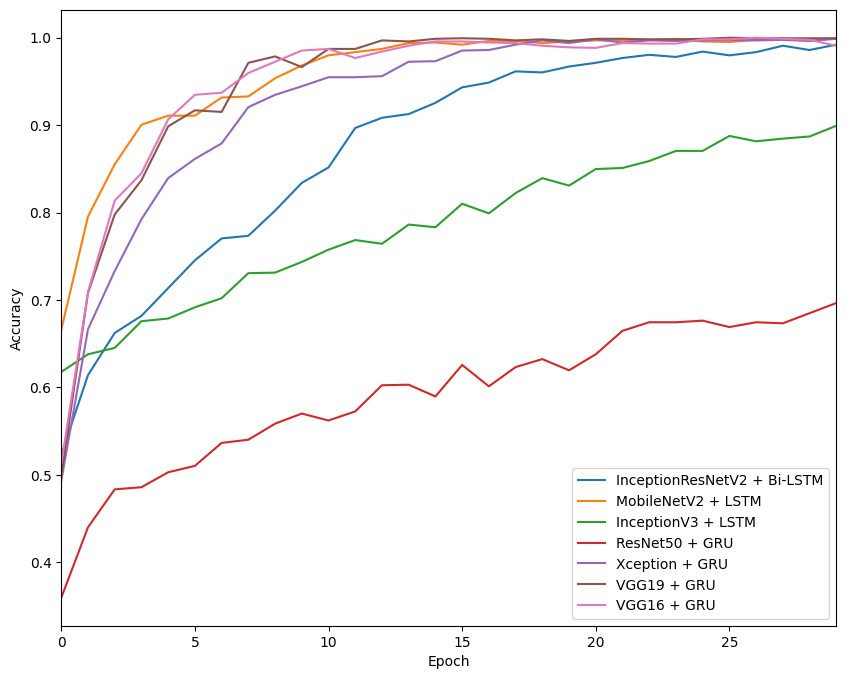

In [53]:
plot(histories=histories, 
     labels=labels, 
     name="accuracy")

## Loss

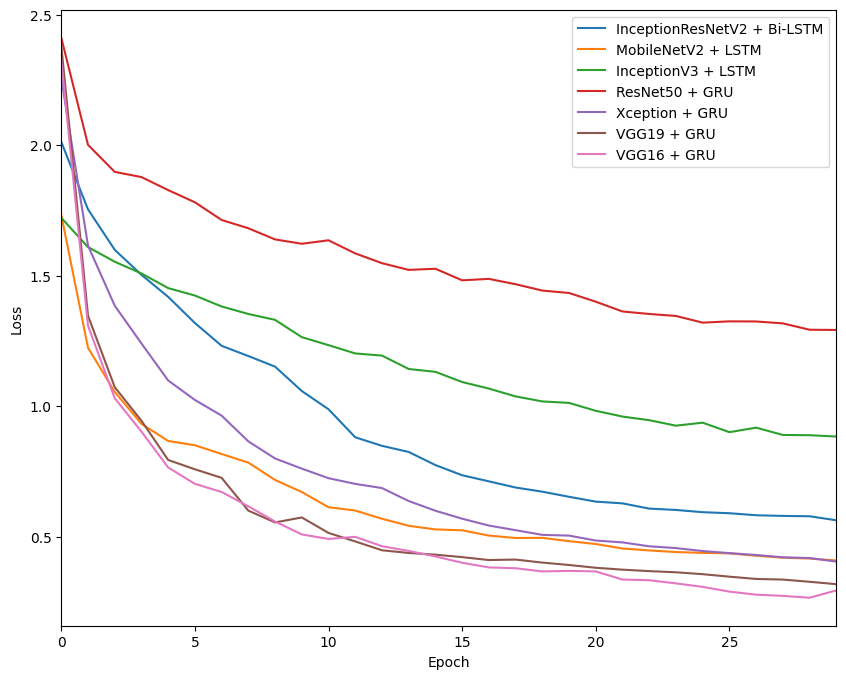

In [54]:
plot(histories=histories, 
     labels=labels, 
     name="loss")

## Validation Accuracy

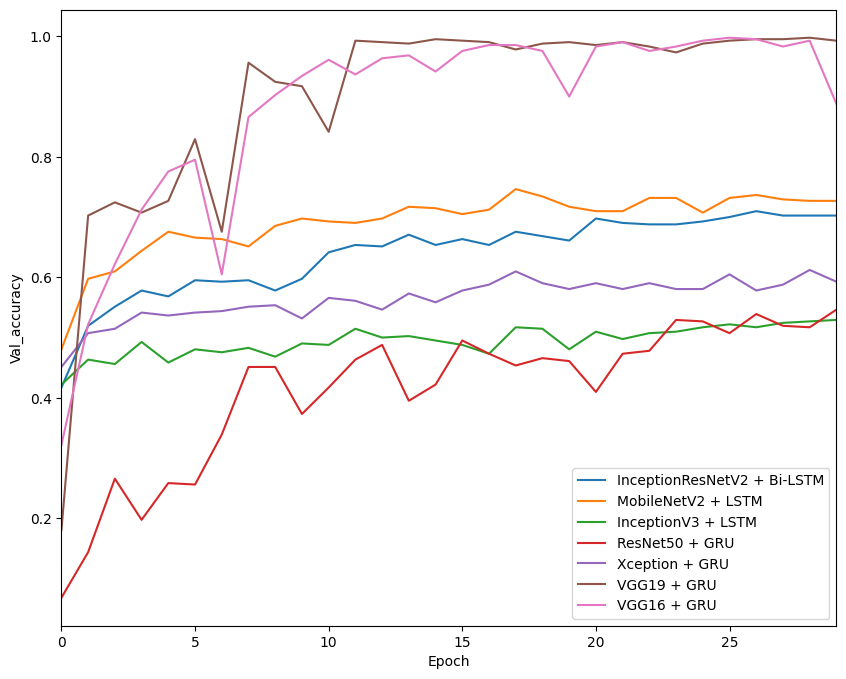

In [55]:
plot(histories=histories, 
     labels=labels, 
     name="val_accuracy")

## Validation Loss

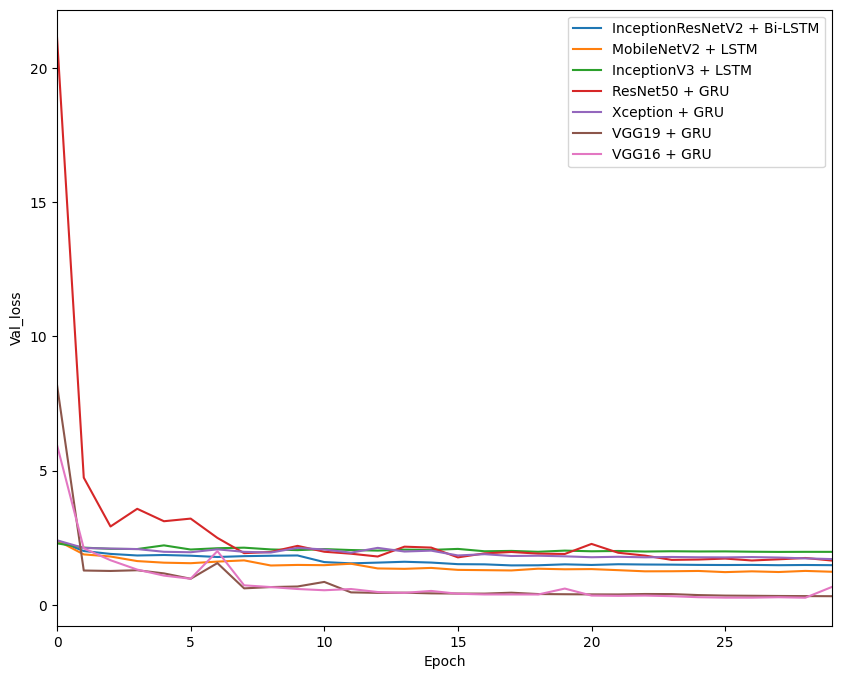

In [56]:
plot(histories=histories, 
     labels=labels, 
     name="val_loss")